<div style="border: 2px solid #4CAF50; border-radius: 10px; padding: 20px; background-color: #f9f9f9;">
  <h1 style="text-align: center; color: #4CAF50;">LV Segmentation with U-Net</h1>
  <p style="font-size: 16px; line-height: 1.6;">
    This project focuses on the segmentation of the Left Ventricle (LV) in medical images using a U-Net model, a type of convolutional neural network designed for image segmentation tasks. The goal is to accurately identify and delineate the LV region in cardiac images, which is crucial for various diagnostic and therapeutic applications. By leveraging the U-Net architecture, this notebook guides you through the entire process, from data loading and preprocessing to model training, evaluation, and visualization of results. The steps are designed to be clear and accessible, making it easy for anyone to follow along and understand the implementation of LV segmentation using deep learning techniques.
  </p>
  <p style="font-size: 18px; font-weight: bold; color: #d9534f; text-align: center;">
    Notably, the model achieved a Mean Intersection over Union (IoU) of 91.8% on the test data, demonstrating its high accuracy and effectiveness.
  </p>
  <ol style="font-size: 16px; line-height: 1.6;">
    <li><strong>Mounting Google Drive:</strong> Accessing the dataset stored in Google Drive.</li>
    <li><strong>Cloning the Repository:</strong> Downloading the necessary code and data from a GitHub repository.</li>
    <li><strong>Installing Packages:</strong> Installing required Python packages for segmentation models.</li>
    <li><strong>Setting Environment Variables:</strong> Configuring environment variables for TensorFlow Keras.</li>
    <li><strong>Importing Libraries:</strong> Importing essential libraries for data processing, model building, and visualization.</li>
    <li><strong>Loading and Preprocessing Data:</strong> Loading images and masks, applying data augmentation, and creating TensorFlow datasets.</li>
    <li><strong>Defining the U-Net Model:</strong> Setting model parameters, defining, compiling, and summarizing the U-Net model.</li>
    <li><strong>Training the Model:</strong> Training the model on the training dataset and validating it on the validation dataset.</li>
    <li><strong>Saving the Model:</strong> Saving the trained model for future use.</li>
    <li><strong>Evaluating the Model:</strong> Evaluating the model's performance using the Mean Intersection over Union (IoU) metric.</li>
    <li><strong>Testing on Random Images:</strong> Testing the model on random images from the validation dataset and visualizing the results.</li>
  </ol>
  <p style="font-size: 16px; line-height: 1.6;">
    By following these steps, you will be able to understand and implement LV segmentation using a U-Net model effectively.
  </p>
</div>


# Mount Google Drive
Mount Google Drive to access the dataset and other files.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Clone GitHub Repository
Clone the repository containing the LV Segmentation with U-Net code and data.

In [2]:
! git clone https://github.com/alandgabriel/LV-Segmentation-with-U-Net.git

Cloning into 'LV-Segmentation-with-U-Net'...
remote: Enumerating objects: 80116, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 80116 (delta 0), reused 3 (delta 0), pack-reused 80113 (from 1)
Receiving objects: 100% (80116/80116), 391.09 MiB | 15.56 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (61969/61969), done.


# Install necessary packages
Install the required packages for segmentation models and specific versions of numpy.

In [5]:
!pip install -U -q segmentation-models
!pip install -q numpy==1.23

# Set environment variable for segmentation models
Set the environment variable to use TensorFlow Keras with segmentation models.

In [6]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Import Libraries
Import all necessary libraries including TensorFlow, segmentation models, and other utilities.

In [7]:
import tensorflow as tf
import os
import glob
import random
import math
import numpy as np
import segmentation_models as sm
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.models import load_model

Segmentation Models: using `tf.keras` framework.


# Load Data
Load and preprocess the data for training and validation.

## Function to load and preprocess images
Define a function to load and preprocess images and masks, including resizing and normalization.

In [8]:
def load_image(image_path, mask_path):
    # Load image and mask
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    image = tf.image.resize(image, (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # Resize to (128, 128)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)  # Normalize to [0, 1]
    mask = tf.image.resize(mask, (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # Resize to (128, 128)

    return image, mask

## Function to build a 2D transformation matrix
Define a function to build a 2D transformation matrix for data augmentation.

In [9]:
def build_2d_transform_matrix(flip=None, offset=None, scale=None, rotate=None):
    transform = tf.eye(3)

    # Apply flip
    if flip and random.random() > 0.5:
        transform = tf.linalg.tensor_diag([flip, flip, 1.0]) @ transform

    # Apply offset
    if offset:
        offset_x = random.uniform(-offset, offset)
        offset_y = random.uniform(-offset, offset)
        offset_matrix = tf.convert_to_tensor([[1, 0, offset_x],
                                              [0, 1, offset_y],
                                              [0, 0, 1]], dtype=tf.float32)
        transform = offset_matrix @ transform
        # if offset is a random number x (offset_x) , y (offset_y) generate ofset in range [-offset, offset]

    # Apply scale
    if scale:
        scale_x = 1.0 + random.uniform(-scale, scale)
        scale_y = 1.0 + random.uniform(-scale, scale)
        scale_matrix = tf.convert_to_tensor([[scale_x, 0, 0],
                                             [0, scale_y, 0],
                                             [0, 0, 1]], dtype=tf.float32)
        transform = scale_matrix @ transform
        # in range [1 - scale, 1 + scale]

    # Apply rotation
    if rotate:
        angle_rad = random.uniform(-rotate, rotate) * math.pi / 180
        rotation_matrix = tf.convert_to_tensor([[tf.cos(angle_rad), -tf.sin(angle_rad), 0],
                                                [tf.sin(angle_rad), tf.cos(angle_rad), 0],
                                                [0, 0, 1]], dtype=tf.float32)
        transform = rotation_matrix @ transform
        # in range [-rotate, rotate]

    # Extract the 2x3 part of the matrix and flatten it to [6]
    transform = transform[:2, :]
    transform = tf.reshape(transform, [6])

    # Append [0, 0] to make it [8] elements
    transform = tf.concat([transform, tf.constant([0.0, 0.0])], axis=0)

    return transform

## Function to apply data augmentation
Define a function to apply data augmentation techniques such as flipping, scaling, rotating, and adding noise.

In [10]:
def data_augmentation(image, mask, flip=None, offset=None, scale=None, rotate=None, noise=None):
    # Build the 2D transformation matrix
    transform_matrix = build_2d_transform_matrix(flip, offset, scale, rotate)

    # The transformation matrix needs to be in shape [1, 8]
    transform_matrix = tf.reshape(transform_matrix, [1, 8])

    # Apply affine transformation using ImageProjectiveTransformV2
    image_shape = tf.shape(image)[:2]
    image = tf.raw_ops.ImageProjectiveTransformV2(
        images=tf.expand_dims(image, 0),
        transforms=transform_matrix,
        output_shape=image_shape,
        interpolation="BILINEAR")[0]

    mask = tf.raw_ops.ImageProjectiveTransformV2(
        images=tf.expand_dims(mask, 0), # convert to [1, height, width, channels]
        transforms=transform_matrix,
        output_shape=image_shape,
        interpolation="NEAREST")[0]

    if noise:
        noise_tensor = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise, dtype=tf.float32)
        image = tf.add(image, noise_tensor)

    return image, tf.cast(mask > 0.5, tf.float32)

## Shuffle and split the data
Shuffle and split the dataset into training and validation sets.

In [11]:
# Directory paths
image_dir = '/content/LV-Segmentation-with-U-Net/DATA/frames'
mask_dir = '/content/LV-Segmentation-with-U-Net/DATA/masks'

In [12]:
# Get list of image and mask file paths
image_paths = glob.glob(os.path.join(image_dir, '*.png'))
mask_paths = [os.path.join(mask_dir, os.path.basename(im)) for im in image_paths]

In [13]:
# Shuffle and split the data
N = len(image_paths)
ixRand = list(range(N)) # list of 0 to N−1
random.shuffle(ixRand)

train_image_paths = [image_paths[i] for i in ixRand[:round(N * 0.8)]]
train_mask_paths = [mask_paths[i] for i in ixRand[:round(N * 0.8)]]

val_image_paths = [image_paths[i] for i in ixRand[round(N * 0.8):]]
val_mask_paths = [mask_paths[i] for i in ixRand[round(N * 0.8):]]

## Create TensorFlow Datasets
Create TensorFlow datasets for training and validation.

In [14]:
# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))

## Set backbone and preprocess input
Set the backbone for the U-Net model and preprocess the input data.

In [21]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

## Apply loading and preprocessing functions
Apply the loading and preprocessing functions to the training and validation datasets.

In [23]:
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(lambda x, y: data_augmentation(x, y, flip=1, offset=0.1, scale=0.2, rotate=10, noise=0.1), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Check loaded data
Check the shapes and unique values of the loaded data to ensure correctness.

In [24]:
# Check loaded data
for image, mask in train_dataset.take(1):
    print(image.shape, mask.shape)
    print(np.unique(mask.numpy()))

(32, 128, 128, 3) (32, 128, 128, 1)
[0. 1.]


## Check loaded data
Check the shapes and unique values of the validation data to ensure correctness.

In [25]:
# Check loaded data
for image, mask in val_dataset.take(1):
    print(image.shape, mask.shape)
    print(np.unique(mask.numpy()))

(32, 128, 128, 3) (32, 128, 128, 1)
[0. 1.]


# Function to display image and mask
Define a function to display an image and its corresponding mask.

In [ ]:
def display_image_mask(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')

    plt.show()

## Display images and masks
Display a few images and their corresponding masks from the training dataset.

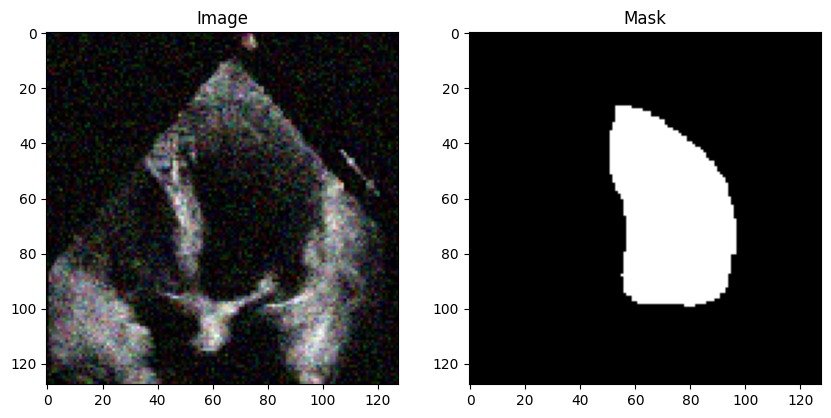

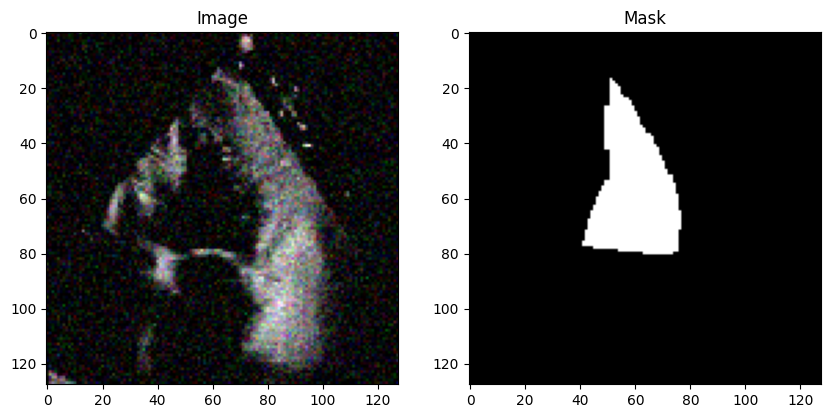

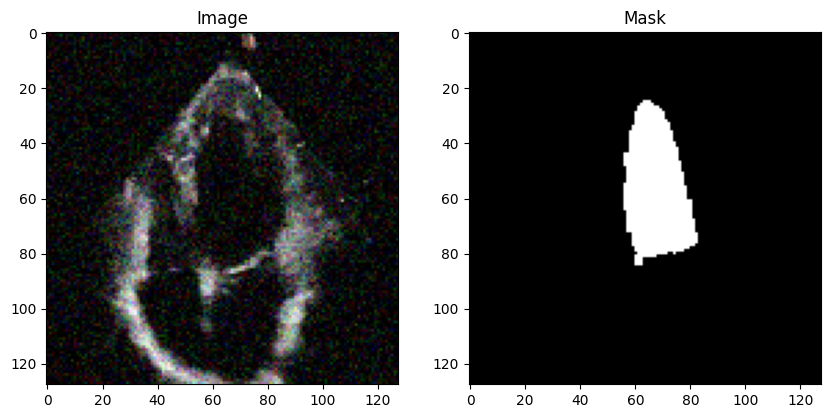

In [14]:
# Take a batch of images and masks from the dataset
for images, masks in train_dataset.take(1):
    for i in range(3):  # Display 3 images and their masks
        image = images[i].numpy()
        mask = masks[i].numpy()
        display_image_mask(image, mask)

# U-Net Model
Define and train the U-Net model for LV segmentation.

## Define model parameters
Set the parameters for the model, including the number of classes, activation function, learning rate, optimizer, loss functions, and metrics.

In [18]:
n_classes = 2
activation = 'softmax'
LR = 0.0001
optim = keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss(class_weights=np.full(n_classes, 0.25))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

## Define model
Initialize the U-Net model with the specified backbone and parameters.

In [16]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

## Compile model
Compile the model with the chosen optimizer, loss functions, and metrics.

In [17]:
model.compile(optim, total_loss, metrics=metrics)

## Display model summary
Print the summary of the model architecture to review its structure.

In [18]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, None, None, 64) │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, None, None, 64) │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, None, None, 64) │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, None, None,     │         73,856 │ block1_pool[0][0]      │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, None, None,     │        147,584 │ block2_conv1[0][0]     │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, None, None,     │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, None, None,     │        295,168 │ block2_pool[0][0]      │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, None, None,     │        590,080 │ block3_conv1[0][0]     │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, None, None,     │        590,080 │ block3_conv2[0][0]     │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, None, None,     │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, None, None,     │      1,180,160 │ block3_pool[0][0]      │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, None, None,     │      2,359,808 │ block4_conv1[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, None, None,     │      2,359,808 │ block4_conv2[0][0]     │
│                           │ 512)                   │                │                        │
├──────────────────────

 Total params: 23,752,418 (90.61 MB)

 Trainable params: 23,748,386 (90.59 MB)

 Non-trainable params: 4,032 (15.75 KB)

None


## Train model
Train the model using the training dataset and validate it on the validation dataset.

In [19]:
history = model.fit(train_dataset, epochs=10, verbose=1, validation_data=val_dataset)

Epoch 1/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 210s 328ms/step - f1-score: 0.3767 - iou_score: 0.3148 - loss: 0.9353 - val_f1-score: 0.4638 - val_iou_score: 0.4230 - val_loss: 0.9073
Epoch 2/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 142s 282ms/step - f1-score: 0.4655 - iou_score: 0.4257 - loss: 0.9068 - val_f1-score: 0.4670 - val_iou_score: 0.4269 - val_loss: 0.9061
Epoch 3/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 126s 250ms/step - f1-score: 0.4679 - iou_score: 0.4303 - loss: 0.9056 - val_f1-score: 0.4673 - val_iou_score: 0.4292 - val_loss: 0.9055
Epoch 4/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 145s 256ms/step - f1-score: 0.4691 - iou_score: 0.4326 - loss: 0.9051 - val_f1-score: 0.4649 - val_iou_score: 0.4277 - val_loss: 0.9054
Epoch 5/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 139s 251ms/step - f1-score: 0.4701 - iou_score: 0.4345 - loss: 0.9048 - val_f1-score: 0.4690 - val_iou_score: 0.4321 - val_loss: 0.9050
Epoch 6/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 144s 255ms/step - f1-score: 0.4710 - iou_score: 0.4363 - loss: 0.9045 - val_f1-s

## Save model
Save the trained model to a file for future use.

In [20]:
model.save('vgg16_Unet_backbone_10epochs.keras')

# Plot training and validation loss & IOU
Visualize the training and validation loss and Intersection over Union (IOU) over the epochs.

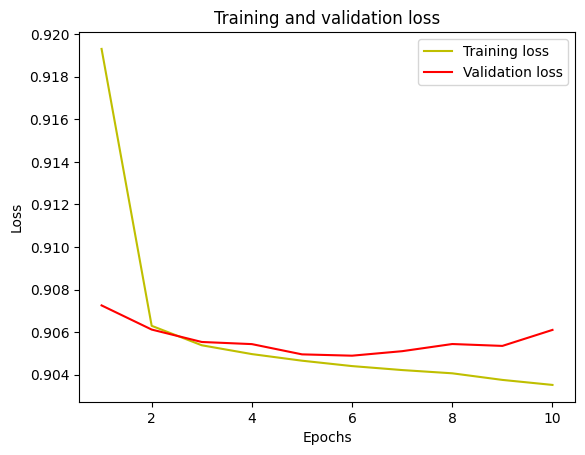

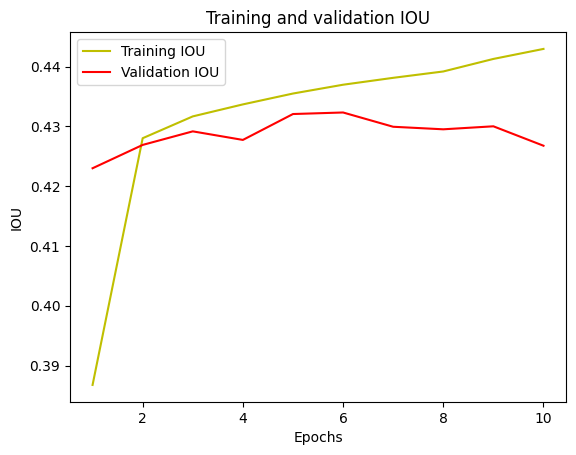

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

## Load trained model
Load the saved trained model for evaluation.

In [26]:
model_path = '/content/drive/MyDrive/vgg16_Unet_backbone_10epochs.keras'
model = load_model(model_path, compile=False)

# Evaluate model with IOU
Evaluate the model on the validation dataset using the Mean Intersection over Union (IOU) metric.

In [27]:
pred = model.predict(val_dataset)
pred_argmax = np.argmax(pred, axis=3)

126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step


In [29]:
IOU_keras = MeanIoU(num_classes=n_classes)

for images, masks in val_dataset:
    predictions = model.predict(images)

    pred_argmax = tf.argmax(predictions, axis=-1)
    pred_argmax = tf.expand_dims(pred_argmax, axis=-1)

    IOU_keras.update_state(masks, pred_argmax)

print("Mean IoU =", IOU_keras.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

# Test random images
Test the model on random images from the validation dataset and display the results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
{0: 479157, 1: 45131}
{0.0: 475856, 1.0: 48432}
Mean IoU = 0.92234474


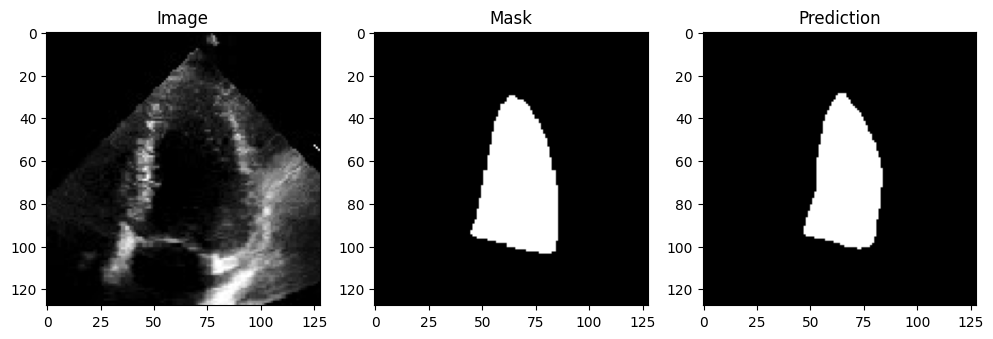

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
{0: 476336, 1: 47952}
{0.0: 473468, 1.0: 50820}
Mean IoU = 0.9231788


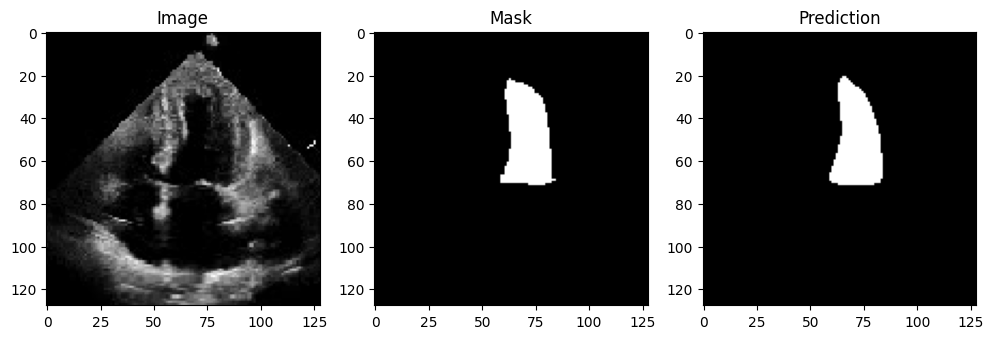

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
{0: 477406, 1: 46882}
{0.0: 474523, 1.0: 49765}
Mean IoU = 0.9159782


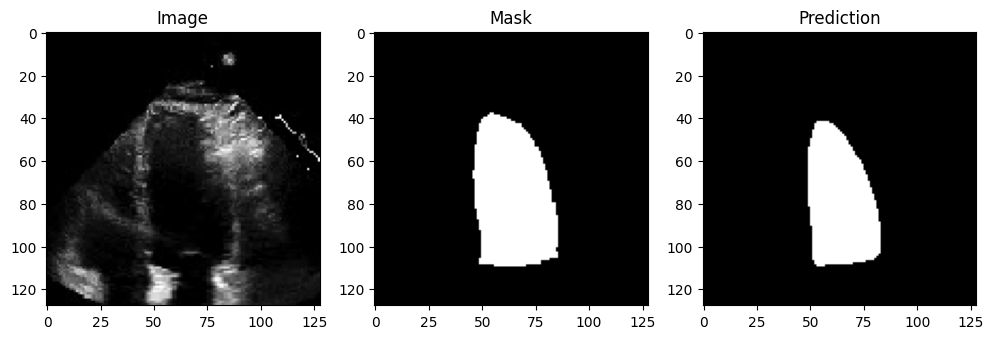

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
{0: 477040, 1: 47248}
{0.0: 475818, 1.0: 48470}
Mean IoU = 0.9231061


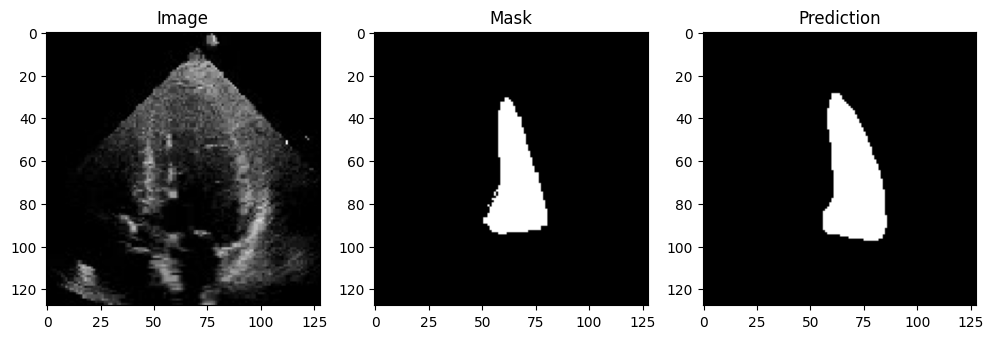

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
{0: 477506, 1: 46782}
{0.0: 473697, 1.0: 50591}
Mean IoU = 0.9136547


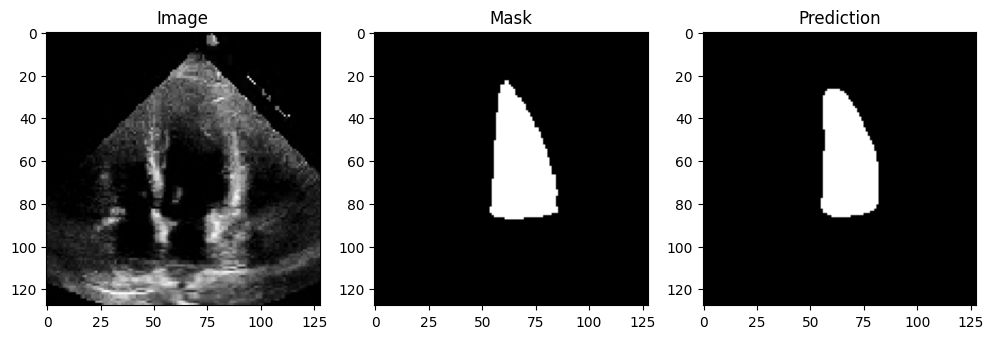

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
{0: 479927, 1: 44361}
{0.0: 477929, 1.0: 46359}
Mean IoU = 0.91653967


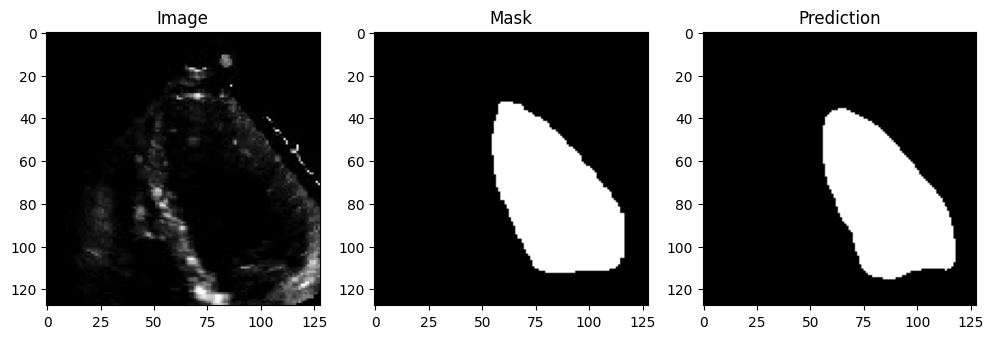

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
{0: 477995, 1: 46293}
{0.0: 474280, 1.0: 50008}
Mean IoU = 0.9106842


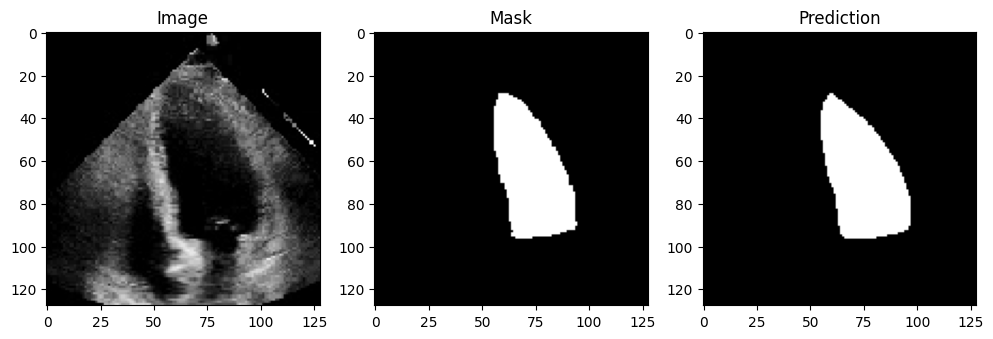

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
{0: 480845, 1: 43443}
{0.0: 479003, 1.0: 45285}
Mean IoU = 0.9180961


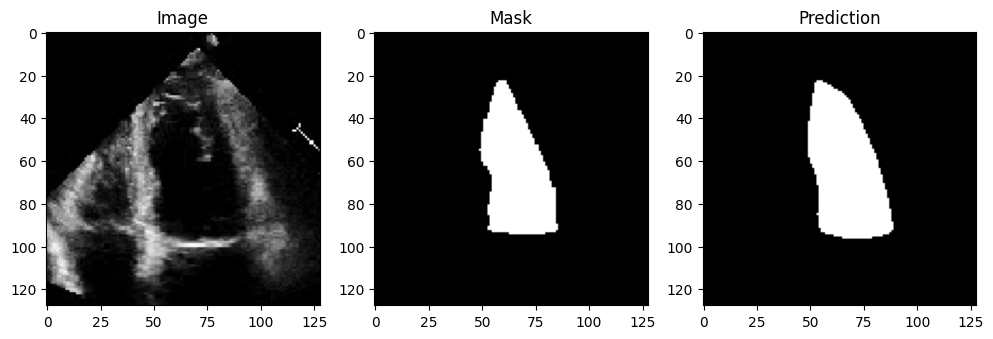

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
{0: 485450, 1: 38838}
{0.0: 482082, 1.0: 42206}
Mean IoU = 0.909994


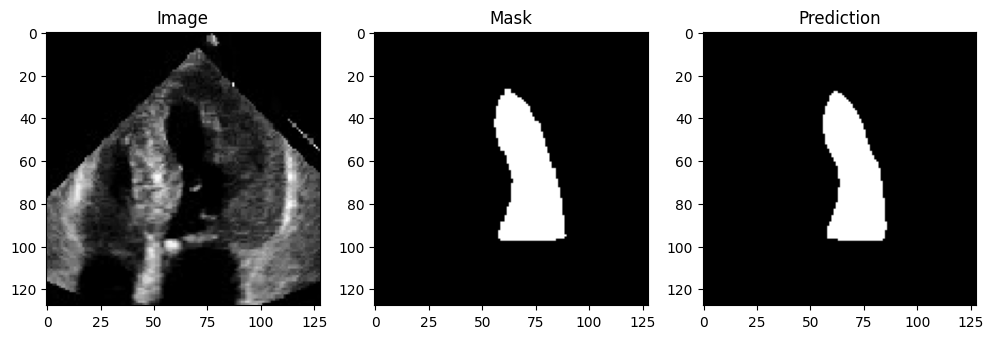

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
{0: 473629, 1: 50659}
{0.0: 468835, 1.0: 55453}
Mean IoU = 0.9109101


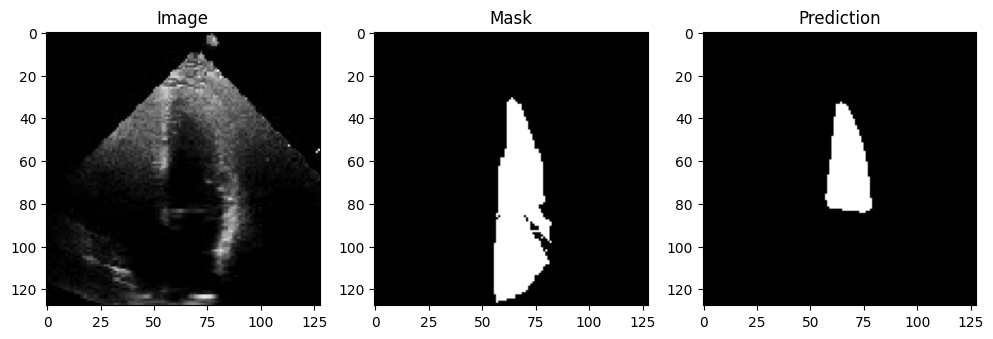

In [30]:
i = 0
for img, mask in val_dataset:
    pred = model.predict(img)
    pred_argmax = np.argmax(pred, axis=3)

    numbers, counts = np.unique(pred_argmax, return_counts=True)
    print(dict(zip(numbers, counts)))

    numbers, counts = np.unique(mask, return_counts=True)
    print(dict(zip(numbers, counts)))

    IOU_keras = MeanIoU(num_classes=n_classes)
    IOU_keras.update_state(mask, pred_argmax)
    print("Mean IoU =", IOU_keras.result().numpy())

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Image')
    plt.imshow(img[0, :, :, 0], cmap='gray')

    plt.subplot(232)
    plt.title('Mask')
    plt.imshow(mask[0, :, :, 0], cmap='gray')

    plt.subplot(233)
    plt.title('Prediction')
    plt.imshow(pred_argmax[0, :, :], cmap='gray')

    plt.show()

    i += 1
    if i == 10:
        break

<h1 style="text-align: center;">The End</h1>